# Video Classification with Apache MXNet

In this notebook, we research and develop architectures for video classification.

We use the UTKinect-Action3D Dataset: http://cvrc.ece.utexas.edu/KinectDatasets/HOJ3D.html, that features 10 classes and 199 records.

The dataset is provided as (1) zipped file of folders of pictures, which are frames of videos containing multiple actions and (2) a text label file providing mapping between picture names and action. So a prominent first step is to build a pipeline that can associate an action - as a sequence of contiguous frames - and a label.

Citation:
* title: View invariant human action recognition using histograms of 3D joints,
* author: Xia, L. and Chen, C.C. and Aggarwal, JK,
* booktitle: Computer Vision and Pattern Recognition Workshops (CVPRW), 2012 IEEE Computer Society Conference on,
 * pages={20--27},
 * year={2012},
 * organization={IEEE}
 
 
Ideas for improvements:
* data augmentation
* different features:
  * add/replace raw data with motion features (eg optical flow)
  * use a pre-trained pose estimation model for feature generation (https://gluon-cv.mxnet.io/build/examples_pose/demo_simple_pose.html)
  * other classification backbone?
* better temporal model (LSTM, conv, ...)
* pre-crop around the person with a detector

## Upload data

In [ ]:
# download videoS
! wget http://cvrc.ece.utexas.edu/KinectDatasets/RGB.zip

In [ ]:
# dowload labels
! wget http://cvrc.ece.utexas.edu/KinectDatasets/actionLabel.txt

In [ ]:
! unzip RGB.zip

### Couple examples of records:

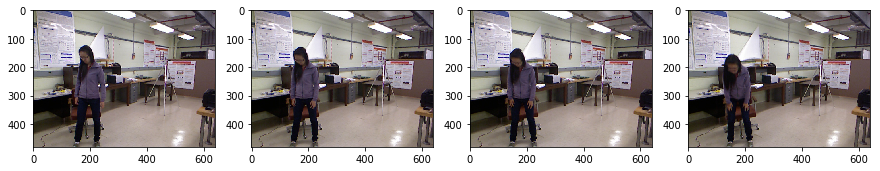

In [1]:
%matplotlib inline

from matplotlib import pyplot as plt
from mxnet import image, nd

plt.rcParams['figure.figsize'] = (15, 5)
plt.rcParams['font.size'] = 10

f, axarr = plt.subplots(1, 4)

for i, item in enumerate(['colorImg572.jpg', 'colorImg584.jpg', 'colorImg590.jpg', 'colorImg600.jpg']):
    
    axarr[i].imshow(image.imread('RGB/s01_e01/' + item).asnumpy())

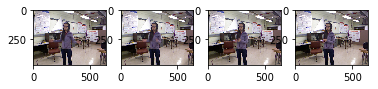

In [2]:
f, axarr = plt.subplots(1, 4)

for i, item in enumerate(['colorImg2110.jpg','colorImg2118.jpg','colorImg2122.jpg','colorImg2128.jpg']):
    
    axarr[i].imshow(image.imread('RGB/s01_e01/' + item).asnumpy())

## Clean metadata and prepare dataset

we'll use the gluon approach, that creates a data pipeline with a `DataLoader` on top of a `Dataset`. The Dataset is a simple abstraction to carry records of arbitrary composition (could be some pandas, some numpy, some complex mix of text and images etc) and the `DataLoader` takes those `Dataset` records and moves them to the appropriate context, while doing transformations and batchification in the process.
https://mxnet.incubator.apache.org/versions/master/tutorials/gluon/datasets.html

Here, data is separated from its labels and the data grain in raw storage is not the same as the data grain we'd like to model so we need to do some pre-processing facilitate the creation of a `Dataset`

In [3]:
import json
import os
import random
import re
import readline

import mxnet as mx
from mxnet import gluon, image, nd, autograd
from mxnet.gluon import nn
from mxnet.gluon.data.vision import transforms
from mxnet.gluon.model_zoo import vision as models
import pandas as pd

We create a rich metadata `DataFrame` with labels and data details

In [4]:
f = open('actionLabel.txt')
lines = f.readlines()

In [5]:
with open('actionLabel.txt', 'r') as f:

    labels = []
    lines = f.readlines()

    for line in lines:
        line = line.rstrip()
        if line.startswith('s') and line.find('_') > -1:
            path = line
        else:
            if "NaN" in line or line == "":
                continue
            framestr = line[line.find(':')+1:].strip()
            start = int(framestr[:framestr.find(' ')])
            stop = int(framestr[framestr.find(' '):])

            # count frames
            allpics = [re.sub("[^0-9]", "", pic) for pic in os.listdir('RGB/' + str(path))]
            allpics = [int(pic) for pic in allpics if pic != '']

            fct = len([f for f in allpics if start <= f <= stop])

            labels.append([line[:line.find(':')], path, start, stop, fct])

In [6]:
annotdf = pd.DataFrame(labels, columns=['label', 'path', 'fstart', 'fstop', 'frames'])

labelmap = {i: L for i, L in enumerate(annotdf['label'].unique())}

# add label ID to the annotations dataframe
annotdf['labelid'] = annotdf['label'].map(lambda x: [k for k in labelmap if labelmap[k] == x][0])

with open('labelmap.json', 'w') as LM:
    json.dump(labelmap, LM)

In [7]:
# shuffle, and split train-test the label file. We'll use that split to create associated gluon Datasets and loaders

sampledf = annotdf.sample(frac=1, random_state=1)

ttsplit = [0.60, 0.30]  # %train, %val, remaining is for test

traindf = annotdf.iloc[:int(len(sampledf)*ttsplit[0])]
valdf = annotdf.iloc[int(len(sampledf)*ttsplit[0]):int(len(sampledf)*(ttsplit[0] + ttsplit[1]))]
testdf = annotdf.iloc[int(len(sampledf)*(ttsplit[0] + ttsplit[1])):]

traindf.reset_index(drop=True).to_csv('train_labels.csv', index=False)
valdf.reset_index(drop=True).to_csv('val_labels.csv', index=False)
testdf.reset_index(drop=True).to_csv('test_labels.csv', index=False)

print(str(len(traindf)) + ' training samples')
print(str(len(valdf)) + ' validation samples')
print(str(len(testdf)) + ' test samples')

119 training samples
60 validation samples
20 test samples


### Create a gluon `Dataset`

In [8]:
def img_prep(img):
    """prepare an RGB image NDArray for ImageNet pre-trained inference"""
    data = mx.image.resize_short(img, 256).astype('float32')
    data, _ = mx.image.center_crop(data, (224,224))
    data = data.transpose((2,0,1))
    return data

In [9]:
class ImageSeqDataset(gluon.data.Dataset):
    """
    Custom Dataset to handle the UTK image sequence dataset json file
    """
    
    def __init__(self, metadata, folder='RGB', downsample=1, framecount=6):
        """
        Parameters
        ---------
        folder: folder storing images. This is the folder containing the path mentioned in the metadata file
        metadata: action metadata file as structured above
        downsample: downsample factor
        framecount: how many frames to keep. Crop after that limit
        records: index of records to select. Use this for train-test split
        """
        self.folder = folder
        self.ds = downsample
        self.fct = framecount
        
        self.annotdf = pd.read_csv(metadata)

        
    def __getitem__(self, idx):
        """
        Parameters
        ---------
        idx: int, index requested

        Returns
        -------
        Tensor: nd.NDArray of seq of images
        label: np.NDArray bounding box labels of the form [[x1,y1, x2, y2, class], ...]
        """
        
        picdir = self.folder + '/' + self.annotdf.loc[idx]['path']
        
        # list available frames
        pathframes = [int(re.sub("[^0-9]", "", pic)) 
            for pic in os.listdir(picdir)]
        
        allframes = [f for f in pathframes if (self.annotdf.iloc[idx]['fstart'] <= f 
                                               and f <= self.annotdf.iloc[idx]['fstop'])]
        allframes.sort()
        
        frames = allframes[:: self.ds][:self.fct]
        pics = ['colorImg' + str(f) + '.jpg' for f in frames]
        
        # if not enough frames, repeating the last one
        while len(pics) < self.fct:
            pics = pics + [pics[-1]]
        
        # return a tensor with all prepared images concatenated
        tensor = nd.concat(*[nd.expand_dims(img_prep(image.imread(picdir + '/' + pic)), axis=0)
                   for pic in pics], dim=0)
        
        labelid = self.annotdf.iloc[idx]['labelid']

        return tensor, labelid
        

    def __len__(self):
        
        return len(self.annotdf)

## Create the network

In [10]:
class PoolingClassifier(gluon.HybridBlock):
    """this network runs a softmax on top of the average-pooled frame imagenet embeddings"""
    
    def __init__(self, num_classes, backbone, fc_width, ctx, dropout_p=0.3):
        
        super(PoolingClassifier, self).__init__()

        self.num_classes = num_classes
        self.backbone = backbone
        self.fc_width = fc_width
        self.dropout_p = dropout_p
               
        with self.name_scope():
            
            self.emb = models.get_model(name=self.backbone, ctx=ctx, pretrained=True).features
            self.dropout_1 = gluon.nn.Dropout(self.dropout_p)
            self.fc1 = gluon.nn.Dense(self.fc_width, activation='relu')
            self.fc2 = gluon.nn.Dense(self.num_classes)

                
    def hybrid_forward(self, F, x):
        
        emb = F.concat(*[F.max(self.emb(ts), axis=0).expand_dims(axis=0) for ts in x], dim=0)
        
        e1 = self.fc1(emb)
        e1 = self.dropout_1(e1)
        Y = self.fc2(e1)
        
        return Y

## Instanciate data pipeline

In [11]:
framecount = 10
dsp = 3
workers = 6

# datasets
trainset = ImageSeqDataset(downsample=dsp, framecount=framecount, metadata='train_labels.csv')
valset = ImageSeqDataset(downsample=dsp, framecount=framecount, metadata='val_labels.csv')
testset = ImageSeqDataset(downsample=dsp, framecount=framecount, metadata='test_labels.csv')

# dataloaders
train_loader = gluon.data.DataLoader(
    dataset=trainset,
    batch_size=16,
    shuffle=True,
    num_workers=workers)

val_loader = gluon.data.DataLoader(
    dataset=valset,
    batch_size=len(valset),
    last_batch='rollover',
    shuffle=False,
    num_workers=workers)

test_loader = gluon.data.DataLoader(
    dataset=testset,
    batch_size=len(testset),
    last_batch='rollover',
    shuffle=False,
    num_workers=workers)

In [12]:
net = PoolingClassifier(num_classes=10, backbone='resnet18_v2', ctx=mx.gpu(), fc_width=16)

In [13]:
ctx=mx.gpu()

net.fc1.initialize(mx.init.Xavier(), ctx=ctx)
net.fc2.initialize(mx.init.Xavier(), ctx=ctx)
net.collect_params().reset_ctx(ctx)

In [14]:
# freeze the resnet part
#for p in net.collect_params().items():
#    if p[0].find('resnet') > -1:
#        p[1].grad_req = 'null'

In [15]:
# check parameter count
net.summary(mx.nd.random.uniform(shape=(1, framecount, 3, 224, 224)).as_in_context(ctx))

--------------------------------------------------------------------------------
        Layer (type)                                Output Shape         Param #
               Input                        (1, 10, 3, 224, 224)               0
         BatchNorm-1                           (10, 3, 224, 224)              12
            Conv2D-2                          (10, 64, 112, 112)            9408
         BatchNorm-3                          (10, 64, 112, 112)             256
        Activation-4                          (10, 64, 112, 112)               0
         MaxPool2D-5                            (10, 64, 56, 56)               0
         BatchNorm-6                            (10, 64, 56, 56)             256
            Conv2D-7                            (10, 64, 56, 56)           36864
         BatchNorm-8                            (10, 64, 56, 56)             256
            Conv2D-9                            (10, 64, 56, 56)           36864
     BasicBlockV2-10        

## Train the network

In [16]:
trainer = gluon.Trainer(
    params=net.collect_params(),
    optimizer=mx.optimizer.create('adam', multi_precision=True, learning_rate=0.001))

metric = mx.metric.Accuracy()
loss_function = gluon.loss.SoftmaxCrossEntropyLoss()

In [17]:
def perf(loader, net):
    
    testmetric = mx.metric.Accuracy()
    for inputs, labels in loader:
        # Possibly copy inputs and labels to the GPU
        inputs = inputs.astype('float16').as_in_context(ctx)
        labels = labels.astype('float16').as_in_context(ctx)
        testmetric.update(labels, net(inputs))
        
    _, value = testmetric.get()    
    return value

In [18]:
net.cast('float16')

num_epochs = 15

train_acc = []
val_acc = []

for epoch in range(num_epochs):
    for inputs, labels in train_loader:
        
        # Possibly copy inputs and labels to the GPU
        inputs = inputs.astype('float16').as_in_context(ctx)
        labels = labels.astype('float16').as_in_context(ctx)

        with autograd.record():
            outputs = net(inputs)
            loss = loss_function(outputs, labels)

        # Compute gradients by backpropagation and update the evaluation metric
        loss.backward()
        metric.update(labels, outputs)

        # Update the parameters by stepping the trainer; the batch size
        # is required to normalize the gradients by `1 / batch_size`.
        trainer.step(batch_size=inputs.shape[0])

    # Print the evaluation metric and reset it for the next epoch
    name, acc = metric.get()
    print('After {} epoch : {} = {}'.format(epoch + 1, name, acc))
    train_acc.append(acc)
    
    metric.reset()
    
    val_perf = perf(val_loader, net)
    print(val_perf)
    val_acc.append(val_perf)

After 1 epoch : accuracy = 0.11764705882352941
0.1
After 2 epoch : accuracy = 0.1092436974789916
0.1
After 3 epoch : accuracy = 0.16806722689075632
0.11666666666666667
After 4 epoch : accuracy = 0.20168067226890757
0.2
After 5 epoch : accuracy = 0.23529411764705882
0.16666666666666666
After 6 epoch : accuracy = 0.17647058823529413
0.2
After 7 epoch : accuracy = 0.23529411764705882
0.18333333333333332
After 8 epoch : accuracy = 0.17647058823529413
0.11666666666666667
After 9 epoch : accuracy = 0.226890756302521
0.16666666666666666
After 10 epoch : accuracy = 0.24369747899159663
0.23333333333333334
After 11 epoch : accuracy = 0.19327731092436976
0.11666666666666667
After 12 epoch : accuracy = 0.226890756302521
0.13333333333333333
After 13 epoch : accuracy = 0.2605042016806723
0.16666666666666666
After 14 epoch : accuracy = 0.24369747899159663
0.15
After 15 epoch : accuracy = 0.24369747899159663
0.16666666666666666


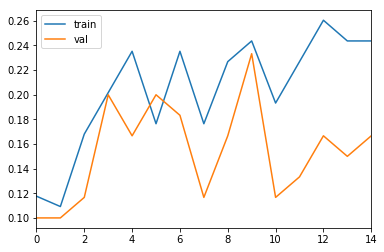

In [19]:
pd.DataFrame(list(zip(train_acc, val_acc)), columns=['train', 'val']).plot()

## Script mode version (optional, wip)
Using SageMaker is a good idea to iterate faster. Below is a first draft of a Script Mode compatible script (out of sync with the above code and not working)

In [ ]:
%%writefile VideoClassif.py

import argparse
import json
import os
import re
import readline
import subprocess as sb
import sys

sb.call([sys.executable, '-m', 'pip', 'install', '-U', 'pandas'])
sb.call([sys.executable, "-m", "pip", "install", "awscli"]) 

import mxnet as mx
from mxnet import gluon, image, nd, autograd
from mxnet.gluon import nn
from mxnet.gluon.model_zoo import vision as models
import pandas as pd




def img_prep(img):
    """prepare an RGB image NDArray for ImageNet pre-trained inference"""
    data = mx.image.resize_short(img, 256).astype('float32')
    data, _ = mx.image.center_crop(data, (224,224))
    data = data.transpose((2,0,1))
    return data




class ImageSeqDataset(gluon.data.Dataset):
    """
    Custom Dataset to handle the UTK image sequence dataset json file
    """
    
    def __init__(self, metadata, folder='RGB', downsample=1, framecount=6):
        """
        Parameters
        ---------
        folder: folder storing images. This is the folder containing the path mentioned in the metadata file
        metadata: action metadata file as structured above
        downsample: downsample factor
        framecount: how many frames to keep. Crop after that limit
        records: index of records to select. Use this for train-test split
        """
        self.folder = folder
        self.ds = downsample
        self.fct = framecount
        
        self.annotdf = pd.read_csv(metadata)

        
    def __getitem__(self, idx):
        """
        Parameters
        ---------
        idx: int, index requested

        Returns
        -------
        Tensor: nd.NDArray of seq of images
        label: np.NDArray bounding box labels of the form [[x1,y1, x2, y2, class], ...]
        """
        
        picdir = self.folder + '/' + self.annotdf.loc[idx]['path']
        
        # list available frames
        pathframes = [int(re.sub("[^0-9]", "", pic)) 
            for pic in os.listdir(picdir)]
        
        allframes = [f for f in pathframes if (self.annotdf.iloc[idx]['fstart'] <= f 
                                               and f <= self.annotdf.iloc[idx]['fstop'])]
        allframes.sort()
        
        frames = allframes[:: self.ds][:self.fct]
        pics = ['colorImg' + str(f) + '.jpg' for f in frames]
        
        # if not enough frames, repeating the last one
        while len(pics) < self.fct:
            pics = pics + [pics[-1]]
        
        
        # return a tensor with all prepared images concatenated
        tensor = nd.concat(*[nd.expand_dims(img_prep(image.imread(picdir + '/' + pic)), axis=0)
                   for pic in pics], dim=0)
        
        labelid = self.annotdf.iloc[idx]['labelid']

        return tensor, labelid
        

    def __len__(self):
        
        return len(self.annotdf)

    


class PoolingClassifier(gluon.HybridBlock):
    """this network runs a softmax on top of the average-pooled frame imagenet embeddings"""
    
    def __init__(self, num_classes, backbone, fc_width, ctx, dropout_p=0.3):
        
        super(PoolingClassifier, self).__init__()

        self.num_classes = num_classes
        self.backbone = backbone
        self.fc_width = fc_width
        self.dropout_p = dropout_p
               
        with self.name_scope():
            
            self.emb = models.get_model(name=self.backbone, ctx=ctx, pretrained=True).features
            self.dropout_1 = gluon.nn.Dropout(self.dropout_p)
            self.dropout_2 = gluon.nn.Dropout(self.dropout_p)
            self.fc1 = gluon.nn.Dense(self.fc_width, activation='relu')
            self.fc2 = gluon.nn.Dense(self.num_classes)

                
    def hybrid_forward(self, F, x):
        
        emb = F.concat(*[F.mean(self.emb(ts), axis=0).expand_dims(axis=0) for ts in x], dim=0)
        
        e1 = self.fc1(emb)
        e1 = self.dropout_1(e1)
        Y = self.fc2(e1)
        
        return Y


    
    
def perf(loader, net):
    
    testmetric = mx.metric.Accuracy()
    for inputs, labels in loader:
        # Possibly copy inputs and labels to the GPU
        inputs = inputs.astype('float16').as_in_context(ctx)
        labels = labels.astype('float16').as_in_context(ctx)
        testmetric.update(labels, net(inputs))
    
    return testmetric.get()

    
    
if __name__ == '__main__':

    parser = argparse.ArgumentParser()

    # extract parameters
    # avoid error when running locally with non-declared os.environ['SM_MODEL_DIR']
    
    parser.add_argument('--backbone', type=str, default='resnet18_v2')
    parser.add_argument('--epochs', type=int, default=10)
    parser.add_argument('--ttsplit', type=float, default=0.7)
    parser.add_argument('--frames', type=int, default=10)
    parser.add_argument('--downsample', type=int, default=2)
    parser.add_argument('--batch', type=int, default=16)
    parser.add_argument('--loadworkers', type=int, default=6)
    parser.add_argument('--fc', type=int, default=32)
    parser.add_argument('--lr', type=float, default=0.001)
    parser.add_argument('--dropout', type=float, default=0.3)


    args, _ = parser.parse_known_args()
        
    
    
    
    # DOWNLOAD DATA ----------------------
    # images
    sb.call(['aws', 's3', 'cp', 's3://cruchant-sm-eu-west1/sagemaker/videoclassif/kinect/RGB.zip', '.'])
    # labels
    sb.call(['wget', 'http://cvrc.ece.utexas.edu/KinectDatasets/actionLabel.txt'])

    sb.call(['unzip', 'RGB.zip'])
    
    
    
    
    # PREPARE METADATA -------------------
    # read raw annotations and produce a clean annot file
    with open('actionLabel.txt', 'r') as f:

        labels = []
        lines = f.readlines()
    
        for line in lines:
            line = line.rstrip()
            if line.startswith('s') and line.find('_') > -1:
                path = line
            else:
                if "NaN" in line or line == "":
                    continue
                framestr = line[line.find(':')+1:].strip()
                start = int(framestr[:framestr.find(' ')])
                stop = int(framestr[framestr.find(' '):])
    
                # count frames
                allpics = [re.sub("[^0-9]", "", pic) for pic in os.listdir('RGB/' + str(path))]
                allpics = [int(pic) for pic in allpics if pic != '']
    
                fct = len([f for f in allpics if start <= f <= stop])
    
                labels.append([line[:line.find(':')], path, start, stop, fct])
            
    
    annotdf = pd.DataFrame(labels, columns=['label', 'path', 'fstart', 'fstop', 'frames'])

    labelmap = {i: L for i, L in enumerate(annotdf['label'].unique())}
    
    # add label ID to the annotations dataframe
    annotdf['labelid'] = annotdf['label'].map(lambda x: [k for k in labelmap if labelmap[k] == x][0])
    
    with open('labelmap.json', 'w') as LM:
        json.dump(labelmap, LM)

        
    # shuffle, and split train-test
    
    sampledf = annotdf.sample(frac=1, random_state=1)
    
    ttsplit = [0.75, 0.20]  # %train, %val, remaining is for test
    
    traindf = annotdf.iloc[:int(len(sampledf)*ttsplit[0])]
    valdf = annotdf.iloc[int(len(sampledf)*ttsplit[0]):int(len(sampledf)*(ttsplit[0] + ttsplit[1]))]
    testdf = annotdf.iloc[int(len(sampledf)*(ttsplit[0] + ttsplit[1])):]
    
    traindf.reset_index(drop=True).to_csv('train_labels.csv', index=False)
    valdf.reset_index(drop=True).to_csv('val_labels.csv', index=False)
    testdf.reset_index(drop=True).to_csv('test_labels.csv', index=False)
    
    print('Annotations shape: ' + str(annotdf.shape))
    
    print(str(len(traindf)) + ' training samples')
    print(str(len(valdf)) + ' validation samples')
    print(str(len(testdf)) + ' test samples')
    
    
    # INSTANCIATE DATA PIPELINE ----------------
    framecount = args.frames

    # datasets
    trainset = ImageSeqDataset(downsample=args.downsample, framecount=framecount, metadata='train_labels.csv')
    testset = ImageSeqDataset(downsample=args.downsample, framecount=framecount, metadata='test_labels.csv')
    
    # dataloaders
    train_loader = gluon.data.DataLoader(
        dataset=trainset,
        batch_size=args.batch,
        shuffle=True,
        num_workers=args.loadworkers)
    
    test_loader = gluon.data.DataLoader(
        dataset=testset,
        batch_size=len(testset),
        last_batch='rollover',
        shuffle=False,
        num_workers=args.loadworkers)
    
    net = PoolingClassifier(num_classes=10, backbone=args.backbone, ctx=mx.gpu(), fc_width=args.fc, dropout_p=args.dropout)
    
    ctx=mx.gpu()

    net.fc1.initialize(mx.init.Xavier(), ctx=ctx)
    net.fc2.initialize(mx.init.Xavier(), ctx=ctx)
    net.collect_params().reset_ctx(ctx)
    
    trainer = gluon.Trainer(
    params=net.collect_params(),
    optimizer=mx.optimizer.create('adam', multi_precision=True, learning_rate=args.lr))

    metric = mx.metric.Accuracy()
    loss_function = gluon.loss.SoftmaxCrossEntropyLoss()
    
    
    net.cast('float16')

    num_epochs = args.epochs
    
    for epoch in range(num_epochs):
        for inputs, labels in train_loader:
            
            # Possibly copy inputs and labels to the GPU
            inputs = inputs.astype('float16').as_in_context(ctx)
            labels = labels.astype('float16').as_in_context(ctx)
    
            with autograd.record():
                outputs = net(inputs)
                loss = loss_function(outputs, labels)
    
            # Compute gradients by backpropagation and update the evaluation metric
            loss.backward()
            metric.update(labels, outputs)
    
            # Update the parameters by stepping the trainer; the batch size
            # is required to normalize the gradients by `1 / batch_size`.
            trainer.step(batch_size=inputs.shape[0])
    
        # Print the evaluation metric and reset it for the next epoch
        name, acc = metric.get()
        print('After epoch {}: {} = {}'.format(epoch + 1, name, acc))
        metric.reset()
        perf(val_loader, net)

In [ ]:
! python VideoClassif.py --backbone resnet18_v2 \
                         --epochs 20 \
                         --ttsplit 0.7 \
                         --frames 15 \
                         --downsample 3 \
                         --batch 16 \
                         --loadworkers 4 \
                         --fc 16 \
                         --lr 0.001

In [ ]:
import sagemaker
from sagemaker import get_execution_role
from sagemaker.mxnet.model import MXNetModel
from sagemaker.mxnet.estimator import MXNet

sess = sagemaker.Session()

model = MXNet(
    entry_point='VideoClassif.py',
    py_version='py3',
    framework_version='1.3',
    train_instance_count=1,
    train_instance_type='ml.p3.2xlarge',
    role=get_execution_role(),
    metric_definitions=[  # publish algo metrics to Cloudwatch
        {'Name': 'train_acc','Regex': "^.*epoch : accuracy = ([0-9.]+).*$"},
        {'Name': 'test_acc','Regex': "Test: accuracy: ([0-9.]+).*$"}],
    hyperparameters={
        'backbone':'densenet121',
        'epochs':'20',
        'ttsplit':'0',
        'frames':'15',
        'downsample':'3',
        'batch':'8',
        'loadworkers':'4',
        'fc':'16',
        'lr':'0.001'})

In [ ]:
model.fit(wait=False)

In [ ]:
# tune
from sagemaker.tuner import ContinuousParameter, IntegerParameter, CategoricalParameter

# Define exploration boundaries
hyperparameter_ranges = {
    'backbone': CategoricalParameter(['resnet18_v2', 'resnet152_v2', 'mobilenetv2_1.0'])
    'lr': ContinuousParameter(0.0005, 0.01),
    'dropout': ContinuousParameter(0.2, 0.8),
    'fc': IntegerParameter(8, 64),
    'frames': IntegerParameter(5, 20),
    'downsample': IntegerParameter(1, 4),
    'batch': IntegerParameter(6, 32)}

# create Optimizer
Optimizer = sagemaker.tuner.HyperparameterTuner(
    estimator=model,
    hyperparameter_ranges=hyperparameter_ranges,
    base_tuning_job_name='HPO-vid-classifier',
    objective_type='Maximize',
    objective_metric_name='test_acc',
    metric_definitions=[{'Name': 'test_acc','Regex': "Test: accuracy: ([0-9.]+).*$"}],    
    max_jobs=300,
    max_parallel_jobs=3)